In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

# Configuraciones para reducir warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

# Filtros espec√≠ficos para warnings conocidos
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
warnings.filterwarnings("ignore", message=".*bert.pooler.*")
warnings.filterwarnings("ignore", message=".*Asking to truncate.*")
warnings.filterwarnings("ignore", message=".*Some weights of the model.*")

print("‚úì Configuraci√≥n de warnings completada - BERT warnings suprimidos")

‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
‚úì Configuraci√≥n de warnings completada - BERT warnings suprimidos


# Modelado de T√≥picos con FASTopic

Este notebook implementa un an√°lisis de t√≥picos usando FASTopic sobre las opiniones tur√≠sticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres sem√°nticamente coherentes a los t√≥picos identificados y compara resultados con BERTopic.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from dotenv import load_dotenv

sys.path.append('../scripts')

from topicos import (
    configurar_clasificador_topicos, 
    configurar_fastopic_inteligente,
    LimpiadorTextoMejorado, 
    mostrar_ejemplos_limpieza,
    evaluar_modelo_topicos,
    extraer_palabras_fastopic,
    mostrar_metricas
)

from topicos.utils_topicos import (
    procesar_topicos_fastopic,
    obtener_asignaciones_topicos_fastopic,
    visualizar_distribucion_topicos_fastopic,
    mostrar_ejemplos_por_topico_fastopic,
    generar_reporte_fastopic
)

load_dotenv()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Device set to use cuda:0
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
clasificador_topicos = configurar_clasificador_topicos()

In [5]:
CIUDAD_ANALIZAR = "Cdmx"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConFASTopic' not in df.columns:
    df['TopicoConFASTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Distribuci√≥n total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

Dataset cargado: 2457 opiniones
Distribuci√≥n total por ciudad:
Ciudad
Mazatlan           499
Puebla             497
Puerto_vallarta    489
Cdmx               489
Cancun             483
Name: count, dtype: int64


In [6]:
columna_limpia = "TituloReviewLimpio"

limpiar_de_nuevo = False

if columna_limpia not in df.columns or limpiar_de_nuevo:
    
    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])
    
    print(f"üîç Iniciando limpieza para {CIUDAD_ANALIZAR}...")
    
    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_traduccion=True,
        filtrar_adjetivos=True,  # Nueva opci√≥n para filtrar adjetivos
        filtrar_solo_espanol=True,  # Nueva opci√≥n para filtrar solo textos en espa√±ol
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None,
        mostrar_estadisticas=True  # Mostrar estad√≠sticas detalladas
    )
    
    print(f"\nüíæ Guardando dataset procesado...")
    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)
    print(f"‚úÖ Dataset guardado exitosamente")

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
texts = df_ciudad[columna_texto].dropna().tolist()

print(f"\nüéØ RESUMEN FINAL PARA {CIUDAD_ANALIZAR}:")
print(f"   üìù Textos disponibles: {len(texts):,}")
if texts:
    promedio = sum(len(t.split()) for t in texts) / len(texts)
    print(f"   üìä Promedio palabras: {promedio:.1f}")
    print(f"   üìè Rango: {min(len(t.split()) for t in texts)} - {max(len(t.split()) for t in texts)} palabras")
    print(f"   üé≤ Muestra: '{texts[0][:50]}...'" if texts else "")


üéØ RESUMEN FINAL PARA Cdmx:
   üìù Textos disponibles: 489
   üìä Promedio palabras: 54.9
   üìè Rango: 13 - 310 palabras
   üé≤ Muestra: 'de simplemente no √©l √©l perder el ballet folkloric...'


In [7]:
model, top_words, doc_topic_dist, reporte_optimizacion, tiempo_entrenamiento = configurar_fastopic_inteligente(texts)
    
print("ü§ñ Configuraci√≥n autom√°tica de FASTopic completada")
print(reporte_optimizacion)

parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:07<00:00, 61.72it/s]       
2025-09-27 09:51:13,316 - TopMost - Real vocab size: 506
parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:07<00:00, 61.72it/s]      
2025-09-27 09:51:13,316 - TopMost - Real vocab size: 506
2025-09-27 09:51:13,317 - TopMost - Real training size: 489 	 avg length: 15.074
2025-09-27 09:51:13,317 - TopMost - Real training size: 489 	 avg length: 15.074
Training FASTopic: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 200/200 [00:20<00:00,  9.93it/s]        

parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:07<00:00, 66.12it/s]       
2025-09-27 09:51:52,301 - TopMost - Real vocab size: 506
2025-09-27 09:51:52,302 - TopMost - Real training size: 489 	 avg length: 15.072
parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:07<00:00, 66.12it/s]    
2025-09-27 09:51:52,301 - TopMost - Real vocab size: 506
2025-09-27 09:51:52,302 - TopMost - Real training size: 489 	 avg l

ü§ñ Configuraci√≥n autom√°tica de FASTopic completada

üìä CONFIGURACI√ìN Y OPTIMIZACI√ìN AUTOM√ÅTICA DE FASTOPIC

üìà An√°lisis del Corpus:
  üìÑ Documentos: 489
  üìù Palabras promedio: 54.9
  üî§ Vocabulario √∫nico: 2,990

üéØ Optimizaci√≥n de T√≥picos:
  üîç Modelos evaluados: 4
  üè∑Ô∏è K √≥ptimo encontrado: 9
  üìà Coherencia CV: 0.4742
  üîÑ Diversidad: 1.0000
  ‚úÖ Criterio diversidad (‚â•0.98): Cumplido

üîß Configuraci√≥n Final:
  üåç Modelo embeddings: paraphrase-multilingual-MiniLM-L12-v2
  üîß Tokenizer: Multiidioma (ES, EN, PT, FR, IT)
  üöÄ √âpocas entrenamiento: 200 (para todos los candidatos)
  ‚è±Ô∏è Tiempo total optimizaci√≥n: 163.58s



In [8]:
# La optimizaci√≥n y entrenamiento ya se realiz√≥ en la celda anterior
topic_model = model
print("‚úÖ Modelo FASTopic optimizado y entrenado autom√°ticamente")

‚úÖ Modelo FASTopic optimizado y entrenado autom√°ticamente


In [22]:
import numpy as np

def select_topics_simple(doc_vec, max_topics=2, diff_threshold=0.10):
    """
    Selecciona t√≥picos de manera simple:
    - Siempre selecciona el t√≥pico con mayor probabilidad
    - Si la diferencia entre el primero y segundo es <= 10%, selecciona tambi√©n el segundo
    - M√°ximo 2 t√≥picos seleccionados por documento
    """
    doc_vec = np.array(doc_vec)
    order = np.argsort(doc_vec)[::-1]  # Ordenar de mayor a menor probabilidad
    
    selected = []
    
    if len(order) > 0:
        # Siempre seleccionar el primero (mayor probabilidad)
        selected.append(order[0])
        
        # Si hay un segundo t√≥pico, verificar la diferencia
        if len(order) > 1 and len(selected) < max_topics:
            first_prob = doc_vec[order[0]]
            second_prob = doc_vec[order[1]]
            
            # Si la diferencia es <= 10%, seleccionar tambi√©n el segundo
            if (first_prob - second_prob) <= diff_threshold:
                selected.append(order[1])
    
    return selected

# Aplicar la nueva l√≥gica simple a todos los documentos
for i, doc in enumerate(doc_topic_dist, 1):
    selected = select_topics_simple(doc)
    probs_str = " | ".join(f"{p:.2f}" for p in doc)
    
    # Mostrar informaci√≥n m√°s clara
    if len(selected) >= 2:
        first_prob = doc[selected[0]]
        second_prob = doc[selected[1]]
        diff = first_prob - second_prob
        print(f"Documento {i}: [{probs_str}] -> T√≥picos: {selected} (Diff: {diff:.3f})")
    else:
        print(f"Documento {i}: [{probs_str}] -> T√≥picos: {selected} (Solo uno)")


Documento 1: [0.08 | 0.03 | 0.01 | 0.02 | 0.42 | 0.11 | 0.06 | 0.07 | 0.18] -> T√≥picos: [4] (Solo uno)
Documento 2: [0.08 | 0.13 | 0.02 | 0.06 | 0.20 | 0.13 | 0.08 | 0.19 | 0.11] -> T√≥picos: [4, 7] (Diff: 0.011)
Documento 3: [0.02 | 0.07 | 0.15 | 0.13 | 0.01 | 0.27 | 0.23 | 0.07 | 0.04] -> T√≥picos: [5, 6] (Diff: 0.043)
Documento 4: [0.04 | 0.06 | 0.09 | 0.32 | 0.03 | 0.05 | 0.20 | 0.03 | 0.19] -> T√≥picos: [3] (Solo uno)
Documento 5: [0.12 | 0.05 | 0.09 | 0.04 | 0.04 | 0.21 | 0.25 | 0.16 | 0.03] -> T√≥picos: [6, 5] (Diff: 0.042)
Documento 6: [0.11 | 0.07 | 0.01 | 0.03 | 0.38 | 0.09 | 0.15 | 0.06 | 0.08] -> T√≥picos: [4] (Solo uno)
Documento 7: [0.22 | 0.03 | 0.04 | 0.02 | 0.03 | 0.40 | 0.15 | 0.03 | 0.08] -> T√≥picos: [5] (Solo uno)
Documento 8: [0.08 | 0.42 | 0.01 | 0.03 | 0.27 | 0.04 | 0.02 | 0.01 | 0.12] -> T√≥picos: [1] (Solo uno)
Documento 9: [0.08 | 0.18 | 0.04 | 0.07 | 0.06 | 0.26 | 0.15 | 0.10 | 0.05] -> T√≥picos: [5, 1] (Diff: 0.080)
Documento 10: [0.03 | 0.04 | 0.01 | 0.83

In [10]:
topic_info = procesar_topicos_fastopic(topic_model, doc_topic_dist, top_words)

# Preparar informaci√≥n de todos los t√≥picos para procesamiento en lote
topics_info_text = ""
for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    keywords = row['Keywords']
    if keywords and keywords not in ["Sin palabras", "Error en procesamiento"]:
        topics_info_text += f"T√≥pico {topic_id}: {keywords}\n"

resultado = clasificador_topicos.invoke({"topics_info": topics_info_text})

topic_names = {}
for topic_label in resultado.topics:
    topic_names[topic_label.topic_id] = topic_label.label

topic_info['Name'] = topic_info['Topic'].map(topic_names)

In [11]:
print(topics_info_text)

T√≥pico 0: acuario, actividad, servicio, gusto, tocar, instalaci√≥n, atracci√≥n, deberiar, experiencia, gustar
T√≥pico 1: plaza, mercado, zocalo, catedral, barrio, restaurante, tienda, calle, comida, cdmx
T√≥pico 2: museo, informacion, hora, encontrar, templo, excavacion, ruina, pieza, deber, sitio
T√≥pico 3: mexico, ciudad, descubrir, fascinante, mantenido, accesible, mexicano, must, pueblo, historio
T√≥pico 4: animal, grupo, pagar, cuidado, horario, ingresar, line, area, falta, boleto
T√≥pico 5: chapultepec, castillo, guia, recorrer, bosque, ocasion, divertido, experimentar, nacional, epoca
T√≥pico 6: arte, mural, obra, artista, coleccion, piso, escultura, art, interior, soumaya
T√≥pico 7: basilica, guadalupe, misa, virgen, iglesia, imagen, juan, capilla, fe, catolico
T√≥pico 8: frida, casa, kahlo, vida, antelacion, fan, frido, accidente, polio, dedicar



In [12]:
print(resultado)

topics=[TopicLabel(topic_id=0, label='Vida marina y actividades interactivas'), TopicLabel(topic_id=1, label='Plazas, mercados y gastronom√≠a'), TopicLabel(topic_id=2, label='Museos y sitios arqueol√≥gicos'), TopicLabel(topic_id=3, label='Ciudades y patrimonio cultural'), TopicLabel(topic_id=4, label='Animales y acceso a atracciones'), TopicLabel(topic_id=5, label='Parques y paseos en la naturaleza'), TopicLabel(topic_id=6, label='Arte, museos y colecciones'), TopicLabel(topic_id=7, label='Religi√≥n y sitios religiosos'), TopicLabel(topic_id=8, label='Vida y obra de artistas famosos')]


In [13]:
# Obtener asignaciones de t√≥picos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Verificar si la ciudad ya ten√≠a resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConFASTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"üîÑ SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   üìù Opiniones con t√≥picos previos: {opiniones_previas}")
    print(f"   üÜï Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")
else:
    print(f"üÜï PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   üìù Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n‚úÖ Actualizaci√≥n completada para {CIUDAD_ANALIZAR}")
print(f"Distribuci√≥n de t√≥picos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualizaci√≥n dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con t√≥pico FASTopic asignado: {df['TopicoConFASTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

üîÑ SOBRESCRIBIENDO resultados previos para Cdmx:
   üìù Opiniones con t√≥picos previos: 489
   üÜï Nuevas asignaciones de t√≥picos: 489

‚úÖ Actualizaci√≥n completada para Cdmx
Distribuci√≥n de t√≥picos en Cdmx:
Topico_Nombre
Ciudades y patrimonio cultural            78
Animales y acceso a atracciones           64
Plazas, mercados y gastronom√≠a            63
Parques y paseos en la naturaleza         60
Vida marina y actividades interactivas    56
Religi√≥n y sitios religiosos              49
Arte, museos y colecciones                45
Museos y sitios arqueol√≥gicos             41
Vida y obra de artistas famosos           33
Name: count, dtype: int64

Porcentaje de opiniones por t√≥pico en Cdmx:
Ciudades y patrimonio cultural: 15.95%
Animales y acceso a atracciones: 13.09%
Plazas, mercados y gastronom√≠a: 12.88%
Parques y paseos en la naturaleza: 12.27%
Vida marina y actividades interactivas: 11.45%
Religi√≥n y sitios religiosos: 10.02%
Arte, museos y colecciones: 9.2%
Museos y si

In [14]:
# Obtener asignaciones de t√≥picos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
indices_ciudad = df_con_topicos.index
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

In [15]:
# Mostrar ejemplos de opiniones por t√≥pico
mostrar_ejemplos_por_topico_fastopic(
    df_con_topicos, 
    topico_col='Topico_Nombre',
    texto_col='TituloReview',
    n_ejemplos=3,
    top_n_topicos=5
)

üìö EJEMPLOS DE OPINIONES POR T√ìPICO

üè∑Ô∏è 1. Ciudades y patrimonio cultural
üìä Total de opiniones: 78
üìù Ejemplos:
   1. Un edificio que data de unos 100 a√±os aproximadamente si es lo que entend√≠ quisa m√°s, el lugar se siente como un viaje en el tiempo , quisa lo han remodelado claro pero mantiene esa esencia,grandes artistas han pasado por esas puertas , incre√≠ble exposiciones artistas mexicanos e internacionales una parada obligada si te encuentras en la ciudad de Mexico. Un edificio que data de unos 100 a√±os aproximadamente si es lo que entend√≠ quisa m√°s, el lugar se siente como un viaje en el tiempo , quisa lo han remodelado claro pero mantiene esa esencia,grandes artistas han pasado por esas puertas , incre√≠ble exposiciones artistas mexicanos e internacionales una parada obligada si te encuentras en la ciudad de Mexico.
   2. Muy bonito. ‚ÄúEs una visita obligatoria si est√°s en la Ciudad de M√©xico, ya que destaca por su belleza en cada rinc√≥n. Cada detalle, de

In [16]:
# ===== COMPARACI√ìN TEXTO ORIGINAL VS TEXTO LIMPIO =====
if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"üîç Comparaci√≥n de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(20, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\nüìÑ EJEMPLO {i} - T√≥pico: {row['Topico_Nombre']}")
        print(f"üî∏ Original: {row['TituloReview']}")
        print(f"üîπ Limpio:   {row['TituloReviewLimpio']}")
        print(f"üìä Probabilidad: {row['Probabilidad_Topico']:.3f}")
        
        # Calcular estad√≠sticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        reduccion = ((len_orig-len_limpio)/len_orig*100) if len_orig > 0 else 0
        print(f"üìâ Reducci√≥n: {len_orig} ‚Üí {len_limpio} caracteres ({reduccion:.1f}%)")
        print("-" * 80)

üîç Comparaci√≥n de ejemplos - Original vs Limpio (Cdmx):

üìÑ EJEMPLO 1 - T√≥pico: Vida marina y actividades interactivas
üî∏ Original: Mi zona favorita de CDMX. La verdad es que nos gust√≥ mucho visitar Coyoac√°n, la experiencia y la vida que se siente en sus calles es muy impresionante. Me parece un buen centro para la cultura y el arte, porque hay muchos lugares para ver. Sus mercaditos son muy coloridos, algunos llenos de actividades incluso. Quiero volver a visitarlo.
üîπ Limpio:   mi zona de cdmx el verdad ser que yo gusto mucho visitar coyoacar el experiencia y el vida que √©l sentir en su calle ser mucho impresionante yo parecer uno buen centro para el cultura y el arte porque haber mucho lugar para ver su mercadito ser mucho colorido alguno lleno de actividad incluso querer volver a visitar √©l
üìä Probabilidad: 0.332
üìâ Reducci√≥n: 339 ‚Üí 320 caracteres (5.6%)
--------------------------------------------------------------------------------

üìÑ EJEMPLO 2 - T√≥pico: 

In [17]:
# ===== VISUALIZACIONES ESPEC√çFICAS DE FASTOPIC =====

# Generar visualizaci√≥n de t√≥picos
fig_topics = topic_model.visualize_topic(top_n=min(8, len(topic_info)))
fig_topics.update_layout(title=f"Palabras Principales por T√≥pico - {CIUDAD_ANALIZAR}")
fig_topics.show()

# Generar visualizaci√≥n de pesos de t√≥picos
fig_weights = topic_model.visualize_topic_weights(top_n=min(10, len(topic_info)))
fig_weights.update_layout(title=f"Distribuci√≥n de Pesos de T√≥picos - {CIUDAD_ANALIZAR}")
fig_weights.show()

# Generar jerarqu√≠a de t√≥picos si hay suficientes
if len(topic_info) >= 3:
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.update_layout(title=f"Jerarqu√≠a de T√≥picos - {CIUDAD_ANALIZAR}")
    fig_hierarchy.show()

print(f"\nüìã Resumen del modelado FASTopic:")
print(f"‚úÖ Textos analizados: {len(texts)}")
print(f"üéØ T√≥picos encontrados: {len(topic_info)}")
print(f"‚è±Ô∏è Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"üìä Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")
print(f"üìà Distribuci√≥n:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")


üìã Resumen del modelado FASTopic:
‚úÖ Textos analizados: 489
üéØ T√≥picos encontrados: 9
‚è±Ô∏è Tiempo de entrenamiento: 163.58s
üìä Probabilidad promedio: 0.481
üìà Distribuci√≥n:
   1. Ciudades y patrimonio cultural: 78 opiniones (16.0%)
   2. Animales y acceso a atracciones: 64 opiniones (13.1%)
   3. Plazas, mercados y gastronom√≠a: 63 opiniones (12.9%)
   4. Parques y paseos en la naturaleza: 60 opiniones (12.3%)
   5. Vida marina y actividades interactivas: 56 opiniones (11.5%)


üîÑ COMPARACI√ìN FASTopic vs BERTopic en Cdmx
üìä Opiniones con ambos an√°lisis: 489

üéØ N√öMERO DE T√ìPICOS:
   BERTopic: 6
   FASTopic: 9


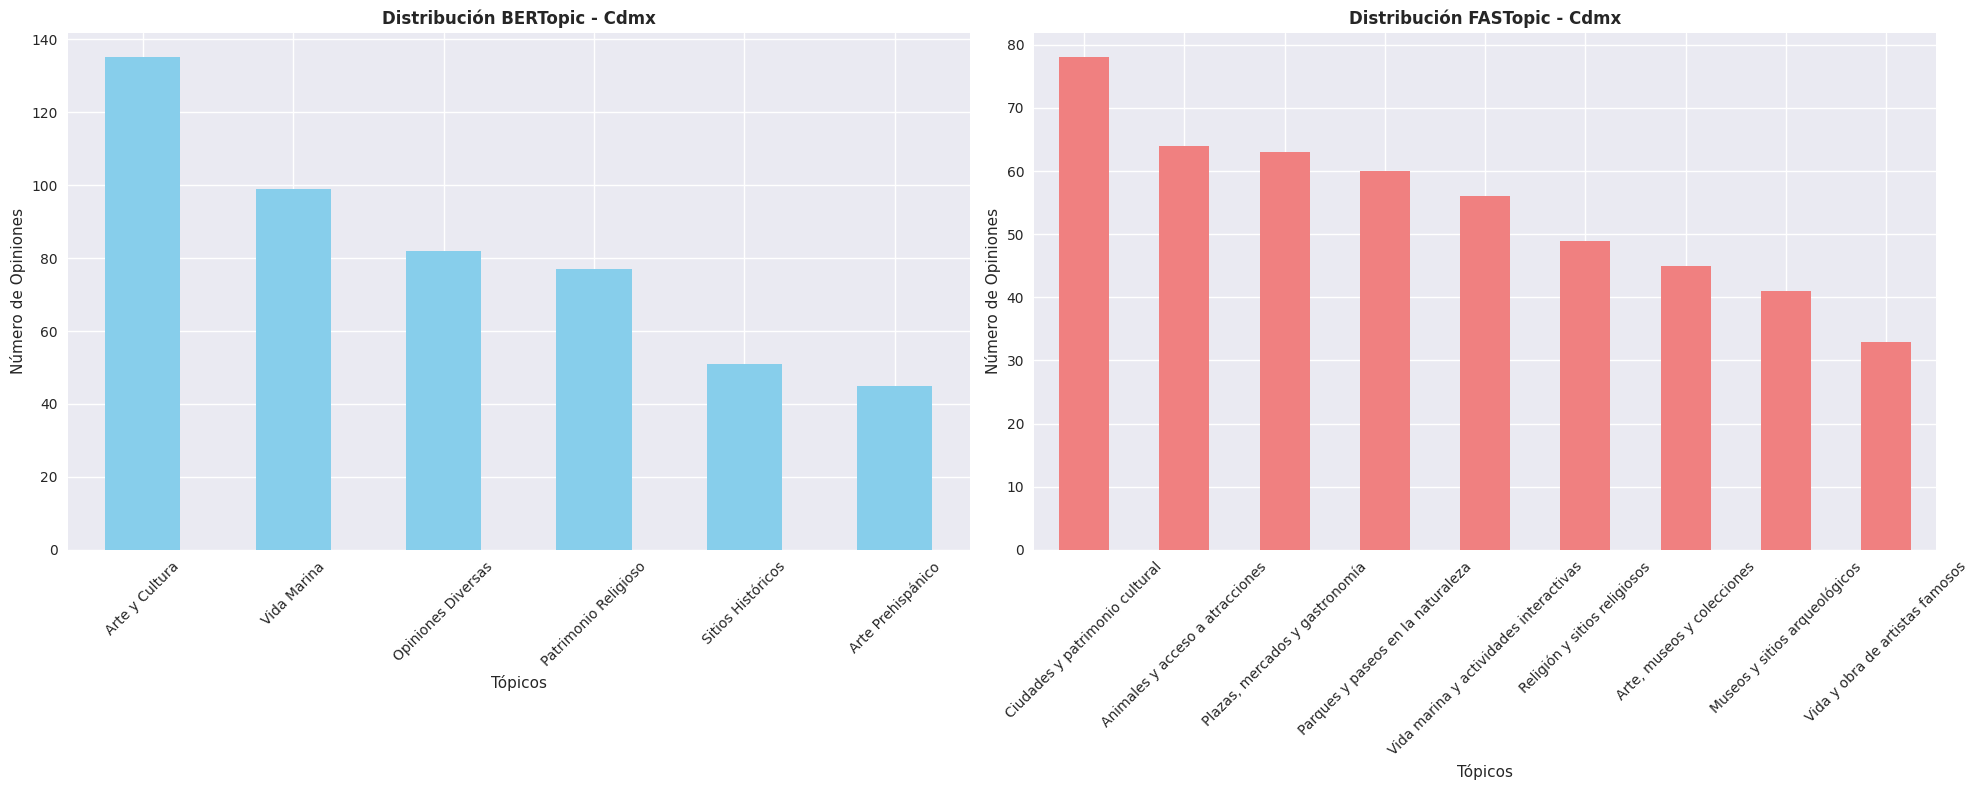


üìà TOP 5 T√ìPICOS POR M√âTODO:

üîµ BERTopic:
   1. Arte y Cultura: 135 (27.6%)
   2. Vida Marina: 99 (20.2%)
   3. Opiniones Diversas: 82 (16.8%)
   4. Patrimonio Religioso: 77 (15.7%)
   5. Sitios Hist√≥ricos: 51 (10.4%)

üî¥ FASTopic:
   1. Ciudades y patrimonio cultural: 78 (16.0%)
   2. Animales y acceso a atracciones: 64 (13.1%)
   3. Plazas, mercados y gastronom√≠a: 63 (12.9%)
   4. Parques y paseos en la naturaleza: 60 (12.3%)
   5. Vida marina y actividades interactivas: 56 (11.5%)

üí° OBSERVACIONES:
   ‚Ä¢ FASTopic identific√≥ 9 t√≥picos vs 6 de BERTopic
   ‚Ä¢ FASTopic muestra mayor granularidad en la segmentaci√≥n
   ‚Ä¢ Tiempo FASTopic: 163.58s (m√°s r√°pido que BERTopic)

üìä RESUMEN ACTUAL FASTopic:
   Total t√≥picos identificados: 9
   T√≥picos en datos actuales: 9
   Documentos procesados: 489


In [18]:
# ===== COMPARACI√ìN CON BERTOPIC =====

if 'TopicoConBERTopic' in df.columns:
    print(f"üîÑ COMPARACI√ìN FASTopic vs BERTopic en {CIUDAD_ANALIZAR}")
    print("=" * 60)
    
    # Usar datos actuales procesados en lugar de df_ciudad que puede tener datos previos
    df_comparacion = df_con_topicos[
        df_con_topicos.index.isin(df_ciudad[df_ciudad['TopicoConBERTopic'].notna()].index)
    ].copy()
    
    # Agregar datos de BERTopic al dataframe de comparaci√≥n
    bertopic_data = df_ciudad[df_ciudad['TopicoConBERTopic'].notna()]['TopicoConBERTopic']
    df_comparacion = df_comparacion[df_comparacion.index.isin(bertopic_data.index)].copy()
    df_comparacion['TopicoConBERTopic'] = bertopic_data
    
    if len(df_comparacion) > 0:
        print(f"üìä Opiniones con ambos an√°lisis: {len(df_comparacion)}")
        
        # Comparar n√∫mero de t√≥picos √∫nicos usando datos actuales
        topicos_bertopic = df_comparacion['TopicoConBERTopic'].nunique()
        topicos_fastopic = df_comparacion['Topico_Nombre'].nunique()  # Usar datos actuales
        
        print(f"\nüéØ N√öMERO DE T√ìPICOS:")
        print(f"   BERTopic: {topicos_bertopic}")
        print(f"   FASTopic: {topicos_fastopic}")
        
        # Mostrar distribuciones lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # BERTopic
        bertopic_counts = df_comparacion['TopicoConBERTopic'].value_counts().head(10)
        bertopic_counts.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribuci√≥n BERTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[0].set_xlabel('T√≥picos')
        axes[0].set_ylabel('N√∫mero de Opiniones')
        axes[0].tick_params(axis='x', rotation=45)
        
        # FASTopic - usar datos actuales
        fastopic_counts = df_comparacion['Topico_Nombre'].value_counts().head(10)
        fastopic_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
        axes[1].set_title(f'Distribuci√≥n FASTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[1].set_xlabel('T√≥picos')
        axes[1].set_ylabel('N√∫mero de Opiniones')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # An√°lisis de concordancia (t√≥picos m√°s frecuentes)
        print(f"\nüìà TOP 5 T√ìPICOS POR M√âTODO:")
        print(f"\nüîµ BERTopic:")
        for i, (topico, count) in enumerate(bertopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
        
        print(f"\nüî¥ FASTopic:")
        for i, (topico, count) in enumerate(fastopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
            
        print(f"\nüí° OBSERVACIONES:")
        print(f"   ‚Ä¢ FASTopic identific√≥ {topicos_fastopic} t√≥picos vs {topicos_bertopic} de BERTopic")
        if topicos_fastopic > topicos_bertopic:
            print(f"   ‚Ä¢ FASTopic muestra mayor granularidad en la segmentaci√≥n")
        elif topicos_fastopic < topicos_bertopic:
            print(f"   ‚Ä¢ FASTopic agrupa conceptos de manera m√°s generalizada")
        else:
            print(f"   ‚Ä¢ Ambos m√©todos identificaron el mismo n√∫mero de t√≥picos")
            
        print(f"   ‚Ä¢ Tiempo FASTopic: {tiempo_entrenamiento:.2f}s (m√°s r√°pido que BERTopic)")
        
        # Mostrar resumen de datos actuales de FASTopic
        print(f"\nüìä RESUMEN ACTUAL FASTopic:")
        print(f"   Total t√≥picos identificados: {len(topic_info)}")
        print(f"   T√≥picos en datos actuales: {df_con_topicos['Topico_Nombre'].nunique()}")
        print(f"   Documentos procesados: {len(df_con_topicos)}")
        
    else:
        print(f"‚ö†Ô∏è No hay opiniones de {CIUDAD_ANALIZAR} con ambos an√°lisis completados")
        print(f"   BERTopic disponible: {df_ciudad['TopicoConBERTopic'].notna().sum()} opiniones")
        print(f"   FASTopic actual: {len(df_con_topicos)} opiniones")
else:
    print(f"‚ÑπÔ∏è No hay an√°lisis previo de BERTopic para comparar")
    print(f"   Ejecuta el notebook 07-modelado-de-topicos-con-bertopic.ipynb primero")
    

In [19]:
generar_reporte_fastopic(
    topic_info, 
    len(df_con_topicos), 
    CIUDAD_ANALIZAR, 
    tiempo_entrenamiento
)

df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

üìã REPORTE COMPLETO - AN√ÅLISIS CON FASTOPIC
üéØ AN√ÅLISIS COMPLETADO:
   üìç Ciudad: Cdmx
   üìÑ Documentos analizados: 489
   üè∑Ô∏è T√≥picos identificados: 9
   ‚è±Ô∏è Tiempo de entrenamiento: 163.58 segundos

üìä ESTAD√çSTICAS DE T√ìPICOS:
   üéØ T√≥pico m√°s relevante: Plazas, mercados y gastronom√≠a
   üìà Peso m√°ximo: 67.932
   üìâ Peso m√≠nimo: 39.476
   üìä Peso promedio: 54.333

üèÜ TOP 5 T√ìPICOS POR RELEVANCIA:
   1. Plazas, mercados y gastronom√≠a
      üìä Peso: 67.932 | üìÑ Documentos: 180
      üîë Palabras clave: plaza, mercado, zocalo, catedral, barrio, restaura...
   2. Vida marina y actividades interactivas
      üìä Peso: 66.320 | üìÑ Documentos: 200
      üîë Palabras clave: acuario, actividad, servicio, gusto, tocar, instal...
   3. Ciudades y patrimonio cultural
      üìä Peso: 63.217 | üìÑ Documentos: 151
      üîë Palabras clave: mexico, ciudad, descubrir, fascinante, mantenido, ...
   4. Animales y acceso a atracciones
      üìä Peso: 6

In [20]:
# ===== EVALUACI√ìN DE M√âTRICAS FASTOPIC =====

print(f"üî¨ Evaluando modelo FASTopic para {CIUDAD_ANALIZAR}...")

topics_words_fastopic = extraer_palabras_fastopic(top_words, words_per_topic=10)
metricas_fastopic = evaluar_modelo_topicos(texts, topics_words_fastopic, f"FASTopic - {CIUDAD_ANALIZAR}")

mostrar_metricas(metricas_fastopic)

üî¨ Evaluando modelo FASTopic para Cdmx...
üìä Evaluaci√≥n FASTopic - Cdmx:
   üéØ T√≥picos: 9
   üìà Coherencia CV: 0.4742
   üîÑ Diversidad: 1.0000
üìä Evaluaci√≥n FASTopic - Cdmx:
   üéØ T√≥picos: 9
   üìà Coherencia CV: 0.4742
   üîÑ Diversidad: 1.0000


In [2]:
# ===== AN√ÅLISIS DETALLADO DE ASIGNACI√ìN DE T√ìPICOS CON REGLA DEL 10% =====

print(f"üìã AN√ÅLISIS DETALLADO DE T√ìPICOS - {CIUDAD_ANALIZAR}")
print("=" * 100)
print(f"Opiniones analizadas: {len(df_con_topicos)}")
print("=" * 100 + "\n")

def aplicar_criterio_diferencia_10_porciento(indice_doc, matriz_probabilidades, diccionario_nombres, umbral_diferencia=0.10):
    """
    Aplica criterio de selecci√≥n basado en diferencia del 10%:
    - T√≥pico principal: siempre se incluye (mayor probabilidad)
    - T√≥pico secundario: solo si diferencia <= 10%
    """
    probabilidades_doc = matriz_probabilidades[indice_doc]
    indices_ordenados = np.argsort(probabilidades_doc)[::-1]
    
    resultado_topicos = []
    resultado_probabilidades = []
    resultado_nombres = []
    
    if len(indices_ordenados) > 0:
        # Procesar t√≥pico principal (obligatorio)
        id_principal = indices_ordenados[0]
        prob_principal = probabilidades_doc[id_principal]
        nombre_principal = diccionario_nombres.get(id_principal, f"T√≥pico_{id_principal}")
        
        resultado_topicos.append(id_principal)
        resultado_probabilidades.append(prob_principal)
        resultado_nombres.append(nombre_principal)
        
        # Evaluar t√≥pico secundario (condicional)
        if len(indices_ordenados) >= 2:
            id_secundario = indices_ordenados[1]
            prob_secundario = probabilidades_doc[id_secundario]
            nombre_secundario = diccionario_nombres.get(id_secundario, f"T√≥pico_{id_secundario}")
            
            # Aplicar criterio del 10%
            diferencia_probabilidades = prob_principal - prob_secundario
            if diferencia_probabilidades <= umbral_diferencia:
                resultado_topicos.append(id_secundario)
                resultado_probabilidades.append(prob_secundario)
                resultado_nombres.append(nombre_secundario)
    
    return resultado_topicos, resultado_probabilidades, resultado_nombres

# Crear DataFrame expandido para an√°lisis completo
df_analisis = df_con_topicos.copy()

# Generar mapeo entre √≠ndices del DataFrame y posiciones en matriz de probabilidades
indices_df = df_analisis.index.tolist()
datos_filtrados = df_ciudad[columna_texto].dropna()
mapeo_posiciones = {indice_real: posicion for posicion, indice_real in enumerate(datos_filtrados.index)}

# Inicializar contenedores para resultados
lista_topicos_primarios = []
lista_probabilidades_primarias = []
lista_topicos_secundarios = []
lista_probabilidades_secundarias = []
lista_flags_segundo_topico = []

# Procesar cada opini√≥n con la l√≥gica del 10%
for indice_actual in indices_df:
    if indice_actual in mapeo_posiciones:
        posicion_matriz = mapeo_posiciones[indice_actual]
        ids_topicos, probabilidades_topicos, nombres_topicos = aplicar_criterio_diferencia_10_porciento(
            posicion_matriz, doc_topic_dist, topic_names
        )
        
        # Asignar t√≥pico primario (siempre presente)
        lista_topicos_primarios.append(nombres_topicos[0])
        lista_probabilidades_primarias.append(probabilidades_topicos[0])
        
        # Evaluar y asignar t√≥pico secundario
        if len(ids_topicos) == 2:  # Cumple criterio del 10%
            lista_topicos_secundarios.append(nombres_topicos[1])
            lista_probabilidades_secundarias.append(probabilidades_topicos[1])
            lista_flags_segundo_topico.append(True)
        else:  # No cumple criterio
            lista_topicos_secundarios.append("N/A")
            lista_probabilidades_secundarias.append(0.0)
            lista_flags_segundo_topico.append(False)
    else:
        # Manejar casos sin mapeo
        lista_topicos_primarios.append("N/A")
        lista_probabilidades_primarias.append(0.0)
        lista_topicos_secundarios.append("N/A")
        lista_probabilidades_secundarias.append(0.0)
        lista_flags_segundo_topico.append(False)

# Enriquecer DataFrame con nuevas columnas
df_analisis['Topico_Primario'] = lista_topicos_primarios
df_analisis['Prob_Primario'] = lista_probabilidades_primarias
df_analisis['Topico_Secundario'] = lista_topicos_secundarios
df_analisis['Prob_Secundario'] = lista_probabilidades_secundarias
df_analisis['Cumple_Criterio_10_Porciento'] = lista_flags_segundo_topico

# Obtener lista de t√≥picos √∫nicos para iteraci√≥n
conjunto_topicos_unicos = df_analisis['Topico_Primario'].unique()
topicos_ordenados = sorted([topico for topico in conjunto_topicos_unicos if topico != "N/A"])

# Contadores para estad√≠sticas globales
contador_opiniones_procesadas = 0
contador_opiniones_con_doble_topico = 0

# Iterar por cada t√≥pico √∫nico
for numero_topico, nombre_topico in enumerate(topicos_ordenados, 1):
    # Filtrar opiniones del t√≥pico actual
    subset_topico = df_analisis[df_analisis['Topico_Primario'] == nombre_topico].copy()
    
    # Ordenar por probabilidad primaria (descendente)
    subset_ordenado = subset_topico.sort_values('Prob_Primario', ascending=False)
    
    # Calcular m√©tricas del grupo
    cantidad_con_segundo = subset_ordenado['Cumple_Criterio_10_Porciento'].sum()
    
    print(f"üéØ T√ìPICO {numero_topico}: {nombre_topico}")
    print(f"üìä Cantidad total: {len(subset_ordenado)}")
    print(f"üìà Probabilidad media: {subset_ordenado['Prob_Primario'].mean():.4f}")
    print(f"üìâ Rango probabil√≠stico: {subset_ordenado['Prob_Primario'].min():.4f} - {subset_ordenado['Prob_Primario'].max():.4f}")
    print(f"üé≠ Con t√≥pico secundario: {cantidad_con_segundo}/{len(subset_ordenado)} ({cantidad_con_segundo/len(subset_ordenado)*100:.1f}%)")
    print("-" * 100)
    
    # Mostrar detalle de cada opini√≥n
    for numero_opinion, (_, fila_opinion) in enumerate(subset_ordenado.iterrows(), 1):
        contador_opiniones_procesadas += 1
        prob_primaria = fila_opinion['Prob_Primario']
        texto_opinion = fila_opinion['TituloReview']
        tiene_segundo_topico = fila_opinion['Cumple_Criterio_10_Porciento']
        
        print(f"üìù Opini√≥n {numero_opinion} (Secuencial #{contador_opiniones_procesadas})")
        print(f"ü•á T√≥pico Primario: {nombre_topico} - Probabilidad: {prob_primaria:.4f}")
        
        if tiene_segundo_topico:
            topico_secundario = fila_opinion['Topico_Secundario']
            prob_secundaria = fila_opinion['Prob_Secundario']
            gap_probabilidades = prob_primaria - prob_secundaria
            print(f"ü•à T√≥pico Secundario: {topico_secundario} - Probabilidad: {prob_secundaria:.4f} (Gap: {gap_probabilidades:.3f})")
            contador_opiniones_con_doble_topico += 1
        else:
            print(f"üö´ T√≥pico √∫nico (gap > 10%)")
        
        print(f"ÔøΩ Texto completo: {texto_opinion}")
        print("-" * 80)
    
    print(f"\n{'='*100}\n")

# Secci√≥n de resumen final
print(f"‚úÖ S√çNTESIS GENERAL:")
print(f"   üéØ T√≥picos √∫nicos identificados: {len(topicos_ordenados)}")
print(f"   üìù Total opiniones procesadas: {contador_opiniones_procesadas}")
print(f"   üé≠ Opiniones con doble t√≥pico (‚â§10%): {contador_opiniones_con_doble_topico}/{contador_opiniones_procesadas} ({contador_opiniones_con_doble_topico/contador_opiniones_procesadas*100:.1f}%)")
print(f"   üìä Consistencia de datos: {contador_opiniones_procesadas == len(df_analisis)}")
print("=" * 100)

# Validaci√≥n de ordenamiento correcto
print(f"\nüîç VALIDACI√ìN DE ORDENAMIENTO:")
for topico_validacion in topicos_ordenados:
    datos_topico = df_analisis[df_analisis['Topico_Primario'] == topico_validacion]
    datos_ordenados = datos_topico.sort_values('Prob_Primario', ascending=False)
    secuencia_probabilidades = datos_ordenados['Prob_Primario'].tolist()
    
    # Verificar orden descendente
    ordenamiento_correcto = all(secuencia_probabilidades[i] >= secuencia_probabilidades[i+1] 
                               for i in range(len(secuencia_probabilidades)-1))
    
    print(f"‚úÖ {topico_validacion}: Orden correcto = {ordenamiento_correcto}")
    if len(secuencia_probabilidades) > 0:
        print(f"   üìä M√°ximo: {max(secuencia_probabilidades):.4f} | M√≠nimo: {min(secuencia_probabilidades):.4f}")

# An√°lisis estad√≠stico de la regla del 10%
print(f"\nüìä AN√ÅLISIS ESTAD√çSTICO DEL CRITERIO 10%:")
opiniones_que_cumplen = df_analisis[df_analisis['Cumple_Criterio_10_Porciento'] == True]

if len(opiniones_que_cumplen) > 0:
    print(f"   üìù Opiniones bajo criterio ‚â§10%: {len(opiniones_que_cumplen)}")
    print(f"   üìà Probabilidad media del secundario: {opiniones_que_cumplen['Prob_Secundario'].mean():.4f}")
    print(f"   üìâ Diferencia media: {(opiniones_que_cumplen['Prob_Primario'] - opiniones_que_cumplen['Prob_Secundario']).mean():.4f}")
    
    # Ranking de t√≥picos secundarios m√°s frecuentes
    print(f"\nü•à TOP 5 T√ìPICOS SECUNDARIOS M√ÅS COMUNES:")
    ranking_secundarios = opiniones_que_cumplen['Topico_Secundario'].value_counts().head(5)
    for posicion, (topico_sec, frecuencia) in enumerate(ranking_secundarios.items(), 1):
        porcentaje = (frecuencia / len(opiniones_que_cumplen) * 100)
        print(f"   {posicion}. {topico_sec}: {frecuencia} apariciones ({porcentaje:.1f}%)")
else:
    print(f"   ‚ö†Ô∏è Ninguna opini√≥n satisface el criterio del 10%")

# An√°lisis de distribuci√≥n de diferencias
coleccion_diferencias = []
for indice_fila in range(len(df_analisis)):
    if df_analisis.iloc[indice_fila]['Cumple_Criterio_10_Porciento']:
        diferencia_calculada = (df_analisis.iloc[indice_fila]['Prob_Primario'] - 
                              df_analisis.iloc[indice_fila]['Prob_Secundario'])
        coleccion_diferencias.append(diferencia_calculada)

if coleccion_diferencias:
    print(f"\nüìè DISTRIBUCI√ìN DE DIFERENCIAS (‚â§10%):")
    print(f"   üìä M√≠nima diferencia: {min(coleccion_diferencias):.4f}")
    print(f"   üìä M√°xima diferencia: {max(coleccion_diferencias):.4f}")
    print(f"   üìä Diferencia promedio: {np.mean(coleccion_diferencias):.4f}")
    
    # Segmentaci√≥n por rangos
    diferencias_muy_pequenas = sum(1 for d in coleccion_diferencias if d <= 0.05)
    diferencias_medianas = sum(1 for d in coleccion_diferencias if 0.05 < d <= 0.10)
    total_diferencias = len(coleccion_diferencias)
    
    print(f"   üìä Diferencias ‚â§ 5%: {diferencias_muy_pequenas} ({diferencias_muy_pequenas/total_diferencias*100:.1f}%)")
    print(f"   üìä Diferencias 5-10%: {diferencias_medianas} ({diferencias_medianas/total_diferencias*100:.1f}%)")

NameError: name 'CIUDAD_ANALIZAR' is not defined